<a href="https://colab.research.google.com/github/JiaweiSMU/Fashain/blob/main/Copy_of_Customer_Lifetime_Value_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lifetimes
!pip install squarify
!pip install KMeans

In [ ]:
# Importing of Library
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import plotly.express as px
import squarify

from sklearn.preprocessing import MinMaxScaler
from lifetimes import GammaGammaFitter
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_period_transactions

import os

In [ ]:
# Uploading of Sales Reciept File
from google.colab import files
uploaded = files.upload()

Saving 201904 sales reciepts.csv to 201904 sales reciepts.csv


In [ ]:
# Read the CSV Data
df_sales = pd.read_csv(io.BytesIO(uploaded['201904 sales reciepts.csv']))
df_sales_cp = df_sales.copy()
df_sales_cp.head()

,transaction_id,transaction_date,transaction_time,sales_outlet_id,staff_id,customer_id,instore_yn,order,line_item_id,product_id,quantity,line_item_amount,unit_price,promo_item_yn
0,7,2019-04-01,12:04:43,3,12,558,N,1,1,52,1,2.50,2.50,N
1,11,2019-04-01,15:54:39,3,17,781,N,1,1,27,2,7.00,3.50,N
2,19,2019-04-01,14:34:59,3,17,788,Y,1,1,46,2,5.00,2.50,N
3,32,2019-04-01,16:06:04,3,12,683,N,1,1,23,2,5.00,2.50,N
4,33,2019-04-01,19:18:37,3,17,99,Y,1,1,34,1,2.45,2.45,N


# Data Prep

In [ ]:
# Count number of unique values for each Col
df_sales_cp.nunique()

transaction_id       4203
transaction_date       29
transaction_time    26074
sales_outlet_id         3
staff_id               25
customer_id          2248
instore_yn              3
order                   9
line_item_id           11
product_id             80
quantity                6
line_item_amount       77
unit_price             41
promo_item_yn           2
dtype: int64

In [ ]:
# Checking for Null Values
df_sales_cp.isnull().sum()

transaction_id      0
transaction_date    0
transaction_time    0
sales_outlet_id     0
staff_id            0
customer_id         0
instore_yn          0
order               0
line_item_id        0
product_id          0
quantity            0
line_item_amount    0
unit_price          0
promo_item_yn       0
dtype: int64

In [ ]:
# To see the type of dataset
df_sales_cp.dtypes

transaction_id        int64
transaction_date     object
transaction_time     object
sales_outlet_id       int64
staff_id              int64
customer_id           int64
instore_yn           object
order                 int64
line_item_id          int64
product_id            int64
quantity              int64
line_item_amount    float64
unit_price          float64
promo_item_yn        object
dtype: object

In [ ]:
# Convert Date Type to a Pandas datetime object
df_sales_cp["transaction_date"] = df_sales_cp["transaction_date"].apply(pd.to_datetime)

In [ ]:
# Finding customer with most Transaction
df_sales_cp.groupby("customer_id").agg({"transaction_id" : "count"}).sort_values(by="transaction_id", ascending=False).head(15)

,transaction_id
customer_id,
0,25033
3,31
8285,31
548,31
8341,29
8009,28
8158,28
8118,28
8036,28


**Sus, that customer with id 0 has 25033 transaction in a span of a month**

In [ ]:
# Create new DF without customer_id == 0
df_sales_cp = df_sales_cp[df_sales_cp["customer_id"] != 0]

In [ ]:
# Create DF for Unique Customer, Append Transaction_Date to It (RFM Analysis)
df_RFM = pd.DataFrame(df_sales_cp['customer_id'].unique())
df_RFM.columns =['customer_id']

# Add latest transaction date for each customer
df_RFM = df_sales_cp.groupby('customer_id')['transaction_date'].max().reset_index()

df_RFM.head()

,customer_id,transaction_date
0,1,2019-04-29
1,2,2019-04-26
2,3,2019-04-24
3,4,2019-04-26
4,5,2019-04-29


# Customer Segment Analysis

**Calculate RFM Metrics**

In [ ]:
# Analyze & Estimate value of a Customer based on Recency, Frequency & Monetary Value
# Recency - How recent did as Customer make a Purchase
# Frequency - How often do Customer make a Purchase
# Monetary Value - How much money does the Customer spend

df_sales_cp["transaction_date"].max()

#Random date to calculate Recency
today = dt.datetime(2019, 5, 1)

# Compute RFM Metric for each Customer
rfm = df_sales_cp.groupby('customer_id').agg({"transaction_date": lambda day: (today - day.max()).days,
                                     "transaction_id" : lambda id: id.nunique(),
                                     "line_item_amount" : "sum"})

# Renaming Column name
rfm.columns = ['recency', 'frequency', 'monetary']

# Filter out row where monetary value > 0, so only Customer who spends money are shown
rfm = rfm[rfm["monetary"] > 0]

rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,2247.0,6.073431,5.248707,2.00,3.0,4.0,7.000,30.00
frequency,2247.0,8.734312,3.749882,1.00,6.0,8.0,11.000,25.00
monetary,2247.0,50.878162,25.645834,2.45,33.2,47.0,65.225,459.75


In [ ]:
# Merging
df_RFM = df_RFM.merge(rfm, on='customer_id')
df_RFM.head()

,customer_id,transaction_date,recency,frequency,monetary
0,1,2019-04-29,2,6,29.20
1,2,2019-04-26,5,16,90.35
2,3,2019-04-24,7,13,188.90
3,4,2019-04-26,5,7,28.75
4,5,2019-04-29,2,6,23.50


In [ ]:
# Create an interactive RFM scatter plot
fig = px.scatter(df_RFM, x='recency', y='monetary', title='RFM Scatter Plot')
fig.show()

# K-Means Clustering for RFM

In [ ]:
KMeans(n_clusters=5)

KMeans(n_clusters=5)

In [ ]:
def sorted_kmeans(df, metric_column, cluster_name, ascending=True, log=False):
    """Runs a K-means clustering algorithm on a specific metric column
    in a Pandas dataframe; sorts the data in a specified direction; and
    reassigns cluster numbers to match the data distribution, so they
    are appropriate for RFM segmentation. Includes a log+1 transformation
    for heavily skewed datasets.

    :param df: Pandas dataframe containing RFM data
    :param metric_column: Column name of metric to cluster, i.e. 'recency'
    :param cluster_name: Name to assign to clustered metric, i.e. 'R'
    :param ascending: Sort ascending (M and F), or descending (R)
    :return
        Original Pandas dataframe with additional column
    """

    if log:
        df[metric_column] = np.log(df[metric_column]+1)

    # Fit the model
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(df[[metric_column]])

    # Assign the initial unsorted cluster
    initial_cluster = 'unsorted_'+cluster_name
    df[initial_cluster] = kmeans.predict(df[[metric_column]])+1
    df[cluster_name] = df[initial_cluster]

    # Group the clusters and re-rank to determine the correct order
    df_sorted = df.groupby(initial_cluster)[metric_column].mean().round(2).reset_index()
    df_sorted = df_sorted.sort_values(by=metric_column, ascending=ascending).reset_index(drop=True)
    df_sorted[cluster_name] = df_sorted[metric_column].rank(method='max', ascending=ascending).astype(int)

    # Merge data and drop redundant columns
    df = df.merge(df_sorted[[cluster_name, initial_cluster]], on=[initial_cluster])
    df = df.drop(initial_cluster, axis=1)
    df = df.drop(cluster_name+'_x', axis=1)
    df = df.rename(columns={cluster_name+'_y':cluster_name})

    return df


In [ ]:
# Put the Data Frame through Sorted KMeans and get Back R, F, M
df_RFM = sorted_kmeans(df_RFM, 'recency', 'R', ascending=False)
df_RFM = sorted_kmeans(df_RFM, 'frequency', 'F', ascending=True)
df_RFM = sorted_kmeans(df_RFM, 'monetary', 'M', ascending=True)
df_RFM.head()

,customer_id,transaction_date,recency,frequency,monetary,R,F,M
0,1,2019-04-29,2,6,29.2,5,2,1
1,5,2019-04-29,2,6,23.5,5,2,1
2,29,2019-04-29,2,6,33.7,5,2,1
3,31,2019-04-29,2,8,34.0,5,2,1
4,56,2019-04-29,2,6,30.2,5,2,1


In [ ]:
df_RFM.groupby('R').agg(
    customers=('customer_id', 'count'),
    min_recency=('recency', min),
    max_recency=('recency', max),
    std_recency=('recency', 'std'),
    avg_recency=('recency', 'mean')
).sort_values(by='avg_recency')

,customers,min_recency,max_recency,std_recency,avg_recency
R,,,,,
5,1205,2,4,0.750307,2.729461
4,587,5,8,1.102347,6.218058
3,267,9,14,1.633769,10.850187
2,129,15,21,1.787120,18.294574
1,59,22,30,2.213740,24.593220


In [ ]:
df_RFM.groupby('F').agg(
    customers=('customer_id', 'count'),
    min_frequency=('frequency', min),
    max_frequency=('frequency', max),
    std_frequency=('frequency', 'std'),
    avg_frequency=('frequency', 'mean')
).sort_values(by='avg_frequency')

,customers,min_frequency,max_frequency,std_frequency,avg_frequency
F,,,,,
1,430,1,5,1.032462,4.062791
2,757,6,8,0.807060,6.972259
3,587,9,11,0.804706,9.902896
4,291,12,14,0.788079,12.766323
5,182,15,25,1.989721,16.884615


In [ ]:
df_RFM.groupby('M').agg(
    customers=('customer_id', 'count'),
    min_monetary=('monetary', min),
    max_monetary=('monetary', max),
    std_monetary=('monetary', 'std'),
    avg_monetary=('monetary', 'mean')
).sort_values(by='avg_monetary')

,customers,min_monetary,max_monetary,std_monetary,avg_monetary
M,,,,,
1,688,2.45,36.30,7.196947,25.836410
2,834,36.40,58.75,6.262647,46.990767
3,562,58.80,88.35,7.714364,70.593007
4,162,88.50,188.90,17.248108,106.323827
5,1,459.75,459.75,NaN,459.750000


In [ ]:
# Create RFM Score for each Customer
df_RFM['rfm'] = df_RFM['R'].astype(str) +\
                      df_RFM['F'].astype(str) +\
                      df_RFM['M'].astype(str)

# Aggregate RFM Score
df_RFM['rfm_score'] = df_RFM['R'].astype(int) +\
                            df_RFM['F'].astype(int) +\
                            df_RFM['M'].astype(int)

# Customer with rfm_score of 3 or rfm of 111 are customer we shouldn't focus on
df_RFM.head()

,customer_id,transaction_date,recency,frequency,monetary,R,F,M,rfm,rfm_score
0,1,2019-04-29,2,6,29.2,5,2,1,521,8
1,5,2019-04-29,2,6,23.5,5,2,1,521,8
2,29,2019-04-29,2,6,33.7,5,2,1,521,8
3,31,2019-04-29,2,8,34.0,5,2,1,521,8
4,56,2019-04-29,2,6,30.2,5,2,1,521,8


In [ ]:
# RFM by Umit Uysal

# Customer segment 	RFM scores
# Star 	542-555
# 	455
# Loyal 	541
# 	511-535
# 	354-454
# Potential loyal 	311-353
# Hold and improve 	211-255
# # Risky 	111-155

# Label it using Umit Uysal Model
# https://dergipark.org.tr/tr/download/article-file/2343280
def label_rfm_segments(rfm):

    if (rfm >= 111) & (rfm <= 155):
        return 'Risky'

    elif (rfm >= 211) & (rfm <= 255):
        return 'Hold and improve'

    elif (rfm >= 311) & (rfm <= 353):
        return 'Potential loyal'

    elif ((rfm >= 354) & (rfm <= 454)) or ((rfm >= 511) & (rfm <= 535)) or (rfm == 541):
        return 'Loyal'

    elif (rfm == 455) or (rfm >= 542) & (rfm <= 555):
        return 'Star'

    else:
        return 'Other'

In [ ]:
# Convert from Type String to Type Int
df_RFM['rfm'] = df_RFM['rfm'].astype(int)

In [ ]:
# Assign Segment Name to customer according to their RFM
df_RFM['rfm_segment_name'] = df_RFM.apply(lambda x: label_rfm_segments(x.rfm), axis=1)
df_RFM.head()

,customer_id,transaction_date,recency,frequency,monetary,R,F,M,rfm,rfm_score,rfm_segment_name
0,1,2019-04-29,2,6,29.2,5,2,1,521,8,Loyal
1,5,2019-04-29,2,6,23.5,5,2,1,521,8,Loyal
2,29,2019-04-29,2,6,33.7,5,2,1,521,8,Loyal
3,31,2019-04-29,2,8,34.0,5,2,1,521,8,Loyal
4,56,2019-04-29,2,6,30.2,5,2,1,521,8,Loyal


In [ ]:
df_RFM.groupby('rfm_segment_name').agg(
    customers=('customer_id', 'count'),
    min_rfm=('rfm', 'min'),
    max_rfm=('rfm', 'max'),
).reset_index().sort_values(by='min_rfm')

,rfm_segment_name,customers,min_rfm,max_rfm
3,Risky,59,111,132
0,Hold and improve,129,211,253
2,Potential loyal,257,311,353
1,Loyal,1494,354,534
4,Star,308,542,555


In [ ]:
# Find  Customers we need to improve / market to
potential_loyal_customers = df_RFM.loc[df_RFM['rfm_segment_name'] == 'Hold and improve']

# Print the filtered DataFrame
potential_loyal_customers.head(5)

,customer_id,transaction_date,recency,frequency,monetary,R,F,M,rfm,rfm_score,rfm_segment_name
246,273,2019-04-11,20,7,34.15,2,2,1,221,5,Hold and improve
247,316,2019-04-12,19,7,29.35,2,2,1,221,5,Hold and improve
248,571,2019-04-12,19,7,34.50,2,2,1,221,5,Hold and improve
249,700,2019-04-13,18,7,29.00,2,2,1,221,5,Hold and improve
250,5004,2019-04-13,18,6,35.40,2,2,1,221,5,Hold and improve


In [ ]:
df_RFM.groupby('rfm_segment_name').agg(
    min_recency=('recency', 'min'),
    max_recency=('recency', 'max'),
    min_frequency=('frequency', 'min'),
    max_frequency=('frequency', 'max'),
    min_monetary=('monetary', 'min'),
    max_monetary=('monetary', 'max'),
).reset_index().sort_values(by='min_recency')

,rfm_segment_name,min_recency,max_recency,min_frequency,max_frequency,min_monetary,max_monetary
1,Loyal,2,13,1,21,2.45,188.90
4,Star,2,4,12,25,45.95,459.75
2,Potential loyal,9,14,1,19,6.00,107.40
0,Hold and improve,15,21,1,15,5.50,99.05
3,Risky,22,30,1,10,3.00,49.75


In [ ]:
df_treemap = df_RFM.groupby('rfm_segment_name').agg(
    customers=('customer_id', 'count')
).reset_index()
df_treemap.head()

,rfm_segment_name,customers
0,Hold and improve,129
1,Loyal,1494
2,Potential loyal,257
3,Risky,59
4,Star,308


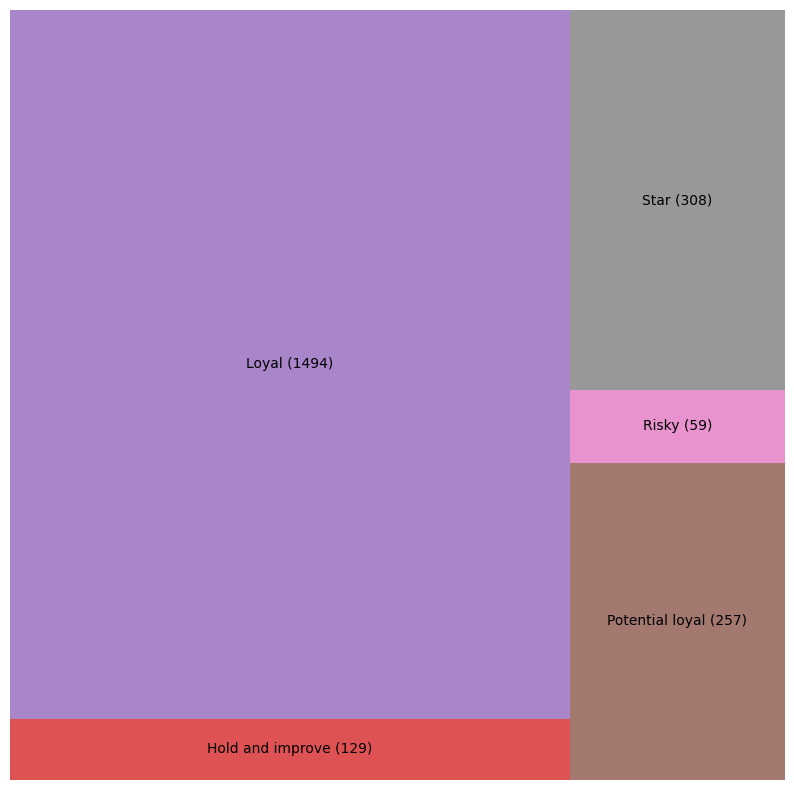

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 10))

# Plot the treemap
squarify.plot(sizes=df_treemap['customers'],
              label=[f"{seg} ({count})" for seg, count in zip(df_treemap['rfm_segment_name'], df_treemap['customers'])],
              alpha=0.8,
              color=['tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
             )

# Turn off axis
plt.axis('off')
plt.show()

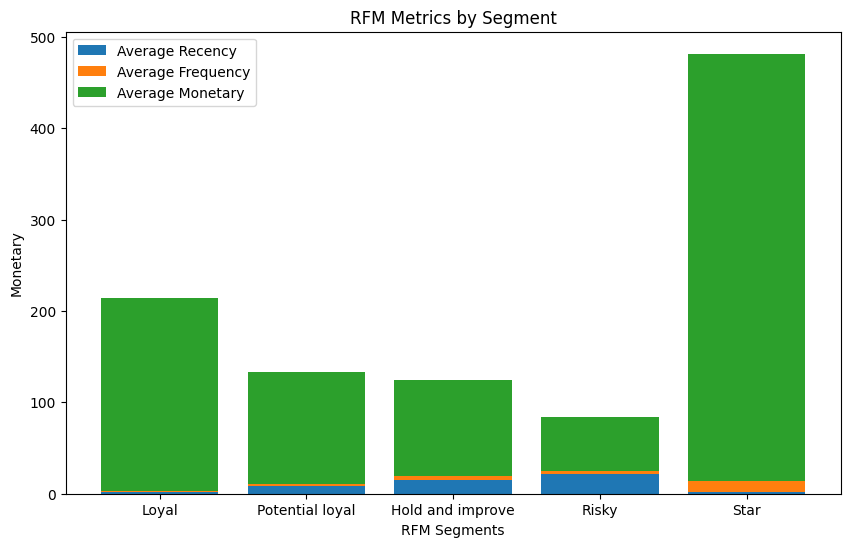

In [ ]:
# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(df_RFM['rfm_segment_name'], df_RFM['recency'], label='Average Recency')
plt.bar(df_RFM['rfm_segment_name'], df_RFM['frequency'], label='Average Frequency', bottom=df_RFM['recency'])
plt.bar(df_RFM['rfm_segment_name'], df_RFM['monetary'], label='Average Monetary', bottom=[r + f for r, f in zip(df_RFM['recency'], df_customer['frequency'])])

# Customize the chart
plt.xlabel('RFM Segments')
plt.ylabel('Monetary')
plt.title('RFM Metrics by Segment')
plt.legend()

# Show the chart
plt.show()

# Customer Lifetime Value

In [ ]:
# Uploading of File
from google.colab import files
uploaded1 = files.upload()

Saving customer.csv to customer.csv


In [ ]:
# Read the CSV Data
df_customers_data = pd.read_csv(io.BytesIO(uploaded1['customer.csv']))
df_customers_data_cp = df_customers_data.copy()
df_customers_data.head()

,customer_id,home_store,customer_first-name,customer_email,customer_since,loyalty_card_number,birthdate,gender,birth_year
0,1,3,Kelly Key,Venus@adipiscing.edu,2017-01-04,908-424-2890,1950-05-29,M,1950
1,2,3,Clark Schroeder,Nora@fames.gov,2017-01-07,032-732-6308,1950-07-30,M,1950
2,3,3,Elvis Cardenas,Brianna@tellus.edu,2017-01-10,459-375-9187,1950-09-30,M,1950
3,4,3,Rafael Estes,Ina@non.gov,2017-01-13,576-640-9226,1950-12-01,M,1950
4,5,3,Colin Lynn,Dale@Integer.com,2017-01-15,344-674-6569,1951-02-01,M,1951


In [ ]:
# Grouping data by customer ID and aggregating relevant metrics
cltv_c = df_sales_cp.groupby('customer_id').agg({
    'transaction_id': lambda x: x.nunique(),  # Count unique transactions
    'quantity': lambda x: x.sum(),  # Total quantity purchased
    'line_item_amount': lambda x: x.sum()  # Total line item amount (revenue)
})

# Renaming the columns for clarity
cltv_c.columns = ['total_transaction', 'total_unit', 'total_price']

cltv_c.head()

,total_transaction,total_unit,total_price
customer_id,,,
1,6,11,29.20
2,16,27,90.35
3,13,45,188.90
4,7,10,28.75
5,6,8,23.50


In [ ]:
# Calculate Average Order Value (AOV)
cltv_c["average_order_value"] = cltv_c["total_price"] / cltv_c["total_transaction"]

# Calculate Purchase Frequency
cltv_c["purchase_frequency"] = cltv_c["total_transaction"] / cltv_c.shape[0]

# Calculate Repeat Rate and Churn Rate
repeat_customers = cltv_c[cltv_c["total_transaction"] > 1]
repeat_rate = repeat_customers.shape[0] / cltv_c.shape[0]
churn_rate = 1 - repeat_rate

# Calculate Profit Margin (assuming 10% profit)
cltv_c['profit_margin'] = cltv_c['total_price'] * 0.10

# Calculate Customer Value
cltv_c["customer_value"] = cltv_c["average_order_value"] * cltv_c["purchase_frequency"]

# Calculate Customer Lifetime Value (CLTV)
cltv_c["CLTV"] = (cltv_c["customer_value"] / churn_rate) * cltv_c["profit_margin"]

# Display the first few rows of the resulting DataFrame
cltv_c.head()

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency,profit_margin,customer_value,CLTV,segment
customer_id,,,,,,,,,
1,6,11,29.20,4.866667,0.002670,2.920,0.012995,7.751273,D
2,16,27,90.35,5.646875,0.007121,9.035,0.040209,74.210205,A
3,13,45,188.90,14.530769,0.005785,18.890,0.084068,324.392818,A
4,7,10,28.75,4.107143,0.003115,2.875,0.012795,7.514205,D
5,6,8,23.50,3.916667,0.002670,2.350,0.010458,5.020455,D


In [ ]:
# Create Segments based on CLTV (Customer Lifetime Value)
# The segments are labeled as D, C, B, and A (from worst to best)
cltv_c["segment"] = pd.qcut(cltv_c["CLTV"], 4, labels=["D", "C", "B", "A"])

# Sort the DataFrame by CLTV in descending order
# This will show the top customers with the highest CLTV first
cltv_c.sort_values(by="CLTV", ascending=False).head()

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency,profit_margin,customer_value,CLTV,segment
customer_id,,,,,,,,,
8311,20,39,459.75,22.987500,0.008901,45.975,0.204606,1921.546023,A
3,13,45,188.90,14.530769,0.005785,18.890,0.084068,324.392818,A
5026,15,35,168.75,11.250000,0.006676,16.875,0.075100,258.877841,A
8144,16,35,165.65,10.353125,0.007121,16.565,0.073721,249.453841,A
8285,25,44,164.05,6.562000,0.011126,16.405,0.073008,244.658205,A


In [ ]:
# Group the data by the "segment" column and aggregate multiple metrics
# Specifically, calculate count, mean, and sum for each segment
cltv_c.groupby("segment").agg({
    "count",  # Number of customers in each segment
    "mean",    # Average CLTV within each segment
    "sum"       # Total CLTV across all customers in each segment
})

total_transaction             total_unit              total_price  \
                     mean   sum count       mean    sum count        mean   
segment                                                                     
D                4.768683  2680   562   8.024911   4510   562   23.850819   
C                7.420213  4185   564  13.235816   7465   564   40.255603   
B                9.610018  5372   559  17.606440   9842   559   55.371377   
A               13.147687  7389   562  24.681495  13871   562   84.096637   

                        average_order_value  ... purchase_frequency  \
              sum count                mean  ...              count   
segment                                      ...                      
D        13404.16   562            5.183878  ...                562   
C        22704.16   564            5.616448  ...                564   
B        30952.60   559            5.971188  ...                559   
A        47262.31   562            6.646105  ...                562   

        profit_margin                 customer_value                   \
                 mean       sum count           mean        sum count   
segment                                                                 
D            2.385082  1340.416   562       0.010615   5.965358   562   
C            4.025560  2270.416   564       0.017915  10.104210   564   
B            5.537138  3095.260   559       0.024642  13.775078   559   
A            8.409664  4726.231   562       0.037426  21.033516   562   

              CLTV                      
              mean           sum count  
segment                                 
D         5.549845   3119.012691   562  
C        14.879272   8391.909151   564  
B        28.113213  15715.285862   559  
A        69.538773  39080.790492   562  

[4 rows x 24 columns]

In [ ]:
# CLTV Prediction

# Function to determine outlier thresholds for a given variable
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# Function to replace outliers with threshold values
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

# Apply outlier replacement to specific columns
replace_with_thresholds(df_sales_cp, "quantity")
replace_with_thresholds(df_sales_cp, "unit_price")

# Create a new column for line item amount (quantity * unit price)
df_sales_cp["line_item_amount"] = df_sales_cp["quantity"] * df_sales_cp["unit_price"]

# Generate summary statistics for the modified DataFrame
df_sales_cp.describe().T

,count,mean,std,min,25%,50%,75%,max
transaction_id,24861.0,892.183339,842.083445,1.0,226.0,519.00,1485.00,4203.0
sales_outlet_id,24861.0,5.240175,2.029637,3.0,3.0,5.00,8.00,8.0
staff_id,24861.0,24.705764,12.169001,6.0,15.0,20.00,30.00,45.0
customer_id,24861.0,4580.439122,3247.865616,1.0,584.0,5417.00,8099.00,8501.0
order,24861.0,1.129037,0.878318,1.0,1.0,1.00,1.00,9.0
line_item_id,24861.0,1.618439,1.416239,1.0,1.0,1.00,1.00,10.0
product_id,24861.0,47.613732,17.515098,1.0,33.0,46.00,59.00,87.0
quantity,24861.0,1.435421,0.527123,1.0,1.0,1.00,2.00,6.0
line_item_amount,24861.0,4.593270,2.894663,0.8,3.0,3.75,6.00,202.8
unit_price,24861.0,3.302543,2.114779,0.8,2.5,3.00,3.75,33.8


In [ ]:
# Calculate Customer Lifetime Value (CLTV) metrics

# Set a reference date (May 1, 2019)
today_date = dt.datetime(2019, 5, 1)

# Group data by customer ID and aggregate relevant metrics
cltv_df = df_sales_cp.groupby("customer_id").agg({
    "transaction_date": [
        lambda date: (date.max() - date.min()).days,  # Recency (days between first and last transaction)
        lambda date: (today_date - date.min()).days  # T (days since the first transaction)
    ],
    "transaction_id": lambda x: x.nunique(),  # Frequency (number of unique transactions)
    "line_item_amount": lambda x: x.sum()  # Monetary value (total revenue)
})

# Clean up column names
cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ["recency", "T", "frequency", "monetary"]

# Calculate average monetary value per transaction
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

# Filter out customers with frequency less than 2
cltv_df = cltv_df[cltv_df["frequency"] > 1]

# Convert recency and T to weeks
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

# Generate summary statistics for the modified DataFrame
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,2236.0,3.239139,0.786577,0.000000,3.0000,3.428571,3.857143,4.000000
T,2236.0,4.096154,0.294837,0.714286,4.0000,4.142857,4.285714,4.285714
frequency,2236.0,8.772361,3.719537,2.000000,6.0000,8.000000,11.000000,25.000000
monetary,2236.0,5.853883,1.451790,2.683333,4.9575,5.590064,6.412500,17.775000


In [ ]:
cltv_df.head()

,recency,T,frequency,monetary
customer_id,,,,
1,3.857143,4.142857,6,4.866667
2,3.571429,4.285714,16,5.646875
3,3.285714,4.285714,13,14.530769
4,3.428571,4.142857,7,4.107143
5,4.000000,4.285714,6,3.916667


# BGF Model

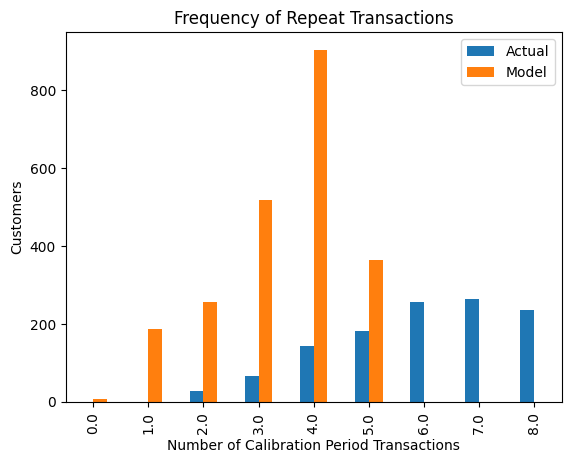

In [ ]:
# Model Customer Behavior & Predict Future Transaction

# Penalize model parameter during fitting to prevent overfitting
bgf = BetaGeoFitter(penalizer_coef=0.001)

# Estimate parameters related to customer behavior
bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

# Visualize the expected number of repeated transaction
plot_period_transactions(bgf)
plt.show()

In [ ]:
cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])

In [ ]:
# Predict how much a Customer would Purchase in a week
bgf.predict(1,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

customer_id
8101    4.334910
8285    4.303410
8297    4.033882
8384    4.033882
548     3.850656
8118    3.850656
8072    3.763954
8341    3.763245
8158    3.726735
8311    3.699975
dtype: float64

In [ ]:
cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

In [ ]:
# Predict how much a Customer would purchase in a month
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

customer_id
8101    16.938963
8285    16.829692
8297    15.773093
8384    15.773093
548     15.055306
8118    15.055306
8072    14.714899
8341    14.713546
8158    14.556905
8311    14.457914
dtype: float64

In [ ]:
# Create a GammaGamma Fitter, and use 0.02 coef to penalize extreme parametere estimates during fitting
ggf = GammaGammaFitter(penalizer_coef=0.02)

# Estimates using Frequency & Monetary
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2236 subjects, p: 2.93, q: 1.79, v: 2.78>

In [ ]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])

In [ ]:
# Calculates Expected Average Profit for each Customer based on their Frequency and Monetary value
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)

customer_id
5495    16.883367
8311    15.062954
3       14.444338
170     13.951914
5125    13.411164
39      13.322476
5027    12.898611
649     12.883106
5582    12.684149
5693    12.677167
dtype: float64

In [ ]:
cltv_df.sort_values("expected_average_profit", ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit
customer_id,,,,,,,
5495,1.000000,1.714286,2,17.775000,1.693144,6.496173,16.883367
8311,3.857143,4.142857,20,15.127500,3.699975,14.457914,15.062954
3,3.285714,4.285714,13,14.530769,2.378037,9.285903,14.444338
170,3.571429,4.142857,5,14.150000,1.595213,6.206852,13.951914
5125,2.285714,4.142857,5,13.580000,1.060623,4.126806,13.411164
39,2.571429,4.000000,8,13.425000,1.583170,6.167779,13.322476
5027,0.857143,3.857143,4,13.075000,0.145464,0.565010,12.898611
649,3.285714,3.857143,6,13.000000,1.800430,7.003920,12.883106
5582,2.000000,4.285714,3,12.900000,0.721195,2.802100,12.684149


In [ ]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,  # 3 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

cltv.head()

customer_id
0    1.204629e-89
1    9.549207e+01
2    2.123983e+02
3    4.003904e+02
4    8.823573e+01
Name: clv, dtype: float64

In [ ]:
cltv = cltv.reset_index()
cltv_final.sort_values(by="clv", ascending=False).head(10)

,customer_id,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv
2043,8311,3.857143,4.142857,20,15.127500,3.700305,14.458753,14.963143,658.789519
2,3,3.285714,4.285714,13,14.530769,2.377874,9.284969,14.301377,403.922102
821,5026,3.142857,4.000000,15,11.250000,2.786922,10.877961,11.148096,368.680216
1780,8048,3.714286,4.000000,14,10.625000,2.929491,11.432317,10.535971,366.093901
2017,8285,4.000000,4.285714,25,6.562000,4.303732,16.830446,6.584993,337.891462
828,5033,4.000000,4.285714,14,10.103571,2.816563,11.000156,10.031164,335.752689
1876,8144,3.285714,4.285714,16,10.353125,2.630937,10.278726,10.282527,321.759386
2073,8341,3.714286,4.285714,22,7.059091,3.763354,14.713529,7.074954,317.250542
340,342,3.428571,4.000000,10,11.745000,2.316701,9.031879,11.572577,317.220977
2142,8410,4.000000,4.285714,18,7.880556,3.358670,13.125599,7.879344,314.981593
